# Benchmarking of various implementations of FADDEEVA's error functions

## I. Setup

Import the multiprecision library `mpmath` as a reference for accuracy benchmarks:

In [1]:
import mpmath

Import the rest of the usual lot:

In [2]:
import numpy as np
import scipy
import ctypes
import sys

The dictionary `wofz_impl` accesses the various function implementations.

Input interface is `wofz_impl[<implementation-folder>](x, y)`: 
`x` is the real and `y` is the imaginary part of the input, both should be numpy arrays (i.e. provide the ctypes field).

In [3]:
wofz_impl = dict()

For argument types needing double pointers, use the ctypes pointer provided by NumPy:

In [4]:
from numpy.ctypeslib import ndpointer
np_double_p = ndpointer(dtype=np.float64)

`ctypes` libraries are loaded into the dictionary `dlls`:

In [5]:
dlls = dict()

### mpmath (reference)

set the precision:

In [6]:
mpmath.mp.dps = 50

prepare the `wofz_impl` entry:

In [7]:
def wofz(x, y):
    z = mpmath.mpc(x, y)
    w = mpmath.exp(-z**2) * mpmath.erfc(z * -1j)
    return w.real, w.imag
wofz_impl['mp'] = np.vectorize(wofz)

### scipy (version > 0.14)

http://ab-initio.mit.edu/wiki/index.php/Faddeeva_Package

In [8]:
from scipy.special import wofz as scipy_wofz

prepare the `wofz_impl` entry:

In [9]:
def wofz(x, y):
    z = scipy_wofz(x + 1j*y)
    return z.real, z.imag
wofz_impl['scipy'] = wofz

### cernlib-c


loading the external shared C library:

In [10]:
dlls['c'] = ctypes.cdll.LoadLibrary('cernlib-c/wofz.so')
dlls['c'].cerrf.restype = None
dlls['c'].cerrf.argtypes = [ctypes.c_double, ctypes.c_double, np_double_p, np_double_p]

prepare the `wofz_impl` entry:

In [11]:
def wofz(x, y):
    in_real = ctypes.c_double(x)
    in_imag = ctypes.c_double(y)
    out_real = np.empty(1, dtype=np.float64)
    out_imag = np.empty(1, dtype=np.float64)
    dlls['c'].cerrf(in_real, in_imag, out_real, out_imag)
    return out_real[0], out_imag[0]
wofz_impl['c'] = np.vectorize(wofz)

### cernlib-cuda-1

try whether PyCUDA is available for the CUDA FADDEEVA version:

In [12]:
i_pycuda = False
try:
    from pycuda.autoinit import context
    from pycuda import gpuarray
    from pycuda.elementwise import ElementwiseKernel
    i_pycuda = True
except ImportError as e:
    print 'No PyCUDA available, as per error message:'
    print e.message

prepare the CUDA kernel for the wofz function:

In [13]:
if i_pycuda:
    kernel = ElementwiseKernel(
        'double* in_real, double* in_imag, double* out_real, double* out_imag',
#         'out_real[i] = in_real[i]; out_imag[i] = in_imag[i]',
        'wofz(in_real[i], in_imag[i], &out_real[i], &out_imag[i]);',
        'wofz_kernel',
        preamble=open('cernlib-cuda-1/wofz.cu', 'r').read()
    )

prepare the `wofz_impl` entry:

In [14]:
if i_pycuda:
    def wofz(x, y):
        in_real = gpuarray.to_gpu(np.atleast_1d(x).astype(np.float64))
        in_imag = gpuarray.to_gpu(np.atleast_1d(y).astype(np.float64))
        out_real = gpuarray.empty(in_real.shape, dtype=np.float64)
        out_imag = gpuarray.empty(in_imag.shape, dtype=np.float64)
        kernel(in_real, in_imag, out_real, out_imag)
        return out_real.get(), out_imag.get()
    wofz_impl['cuda'] = wofz

### cernlib-f90-1

import and numpy-vectorise the first f90 version:

In [15]:
sys.path.append('cernlib-f90-1')
from wwerf import ccperrfr

wofz_impl['f90-1'] = np.vectorize(ccperrfr)

### cernlib-f90-2

import and numpy-vectorise the second f90 version:

In [16]:
sys.path.append('cernlib-f90-2')
from wwerf2 import errf

wofz_impl['f90-2'] = np.vectorize(errf)

### cernlib-python-1

In [17]:
sys.path.append('cernlib-python-1')
from mywwerf import wwerf

wofz_impl['py'] = np.vectorize(wwerf)

### cernlib-root-adapted

In [18]:
dlls['c-root-adapt'] = ctypes.cdll.LoadLibrary('cernlib-root-adapted/liberfc.so')
dlls['c-root-adapt'].cerf.restype = None
dlls['c-root-adapt'].cerf.argtypes = [ctypes.c_double, ctypes.c_double, np_double_p, np_double_p]

def wofz_root(x, y):
    in_real = ctypes.c_double(x)
    in_imag = ctypes.c_double(y)
    out_real = np.empty(1, dtype=np.float64)
    out_imag = np.empty(1, dtype=np.float64)
    dlls['c-root-adapt'].cerrf(in_real, in_imag, out_real, out_imag)
    return out_real[0], out_imag[0]
wofz_impl['c-root-adapt'] = np.vectorize(wofz)

### cernlib-root-adapted -DFAST_IMPL

In [19]:
dlls['c-root-adapt-fast'] = ctypes.cdll.LoadLibrary('cernlib-root-adapted/liberfc_fast.so')
dlls['c-root-adapt-fast'].cerf.restype = None
dlls['c-root-adapt-fast'].cerf.argtypes = [ctypes.c_double, ctypes.c_double, np_double_p, np_double_p]

def wofz_root(x, y):
    in_real = ctypes.c_double(x)
    in_imag = ctypes.c_double(y)
    out_real = np.empty(1, dtype=np.float64)
    out_imag = np.empty(1, dtype=np.float64)
    dlls['c-root-adapt-fast'].cerrf(in_real, in_imag, out_real, out_imag)
    return out_real[0], out_imag[0]
wofz_impl['c-root-adapt-fast'] = np.vectorize(wofz)

### cernlib-root-adapted -DSINCOS

In [20]:
dlls['c-root-adapt-sincos'] = ctypes.cdll.LoadLibrary('cernlib-root-adapted/liberfc_sincos.so')
dlls['c-root-adapt-sincos'].cerf.restype = None
dlls['c-root-adapt-sincos'].cerf.argtypes = [ctypes.c_double, ctypes.c_double, np_double_p, np_double_p]

def wofz_root(x, y):
    in_real = ctypes.c_double(x)
    in_imag = ctypes.c_double(y)
    out_real = np.empty(1, dtype=np.float64)
    out_imag = np.empty(1, dtype=np.float64)
    dlls['c-root-adapt-sincos'].cerrf(in_real, in_imag, out_real, out_imag)
    return out_real[0], out_imag[0]
wofz_impl['c-root-adapt-sincos'] = np.vectorize(wofz)

## II. Accuracy Benchmark

### dirty hands-on, just trying what happens:

In [21]:
wofz_impl['scipy'](3, 2)

(0.092710766426443436, 0.12831696222826169)

In [22]:
wofz_impl['c'](3, 2)

(array(0.09271076642644314), array(0.12831696222826672))

In [23]:
wofz_impl['cuda'](3, 2)

(array([ 0.09271077]), array([ 0.12831696]))

In [24]:
wofz_impl['f90-1'](3, 2)

(array(0.09271077124408933), array(0.12831696889616245))

In [25]:
wofz_impl['f90-2'](3, 2)

(array(0.09271076642644314), array(0.12831696222826672))

In [26]:
wofz_impl['py'](3, 2)

(array(0.05763486477626666), array(0.035177087006951484))

In [27]:
wofz_impl['c-root-adapt'](3, 2)

(array([ 0.09271077]), array([ 0.12831696]))

In [28]:
wofz_impl['c-root-adapt-fast'](3, 2)

(array([ 0.09271077]), array([ 0.12831696]))

In [29]:
wofz_impl['c-root-adapt-sincos'](3, 2)

(array([ 0.09271077]), array([ 0.12831696]))

#### ^^^!!!

.

.

.

.

### Accuracy within range 10^-8 to 10^8

(outside of this, the `mpmath` multiplications of extremely large and small factors do not behave well)

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

define range:

In [28]:
exp_min = -8
exp_max = 8

r = 10**np.linspace(exp_min, exp_max, 101)
x, y = np.meshgrid(r, r)

the reference values via `mpmath`:

In [29]:
wr_ref, wi_ref = wofz_impl['mp'](x, y)

/home/shegglin/miniconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


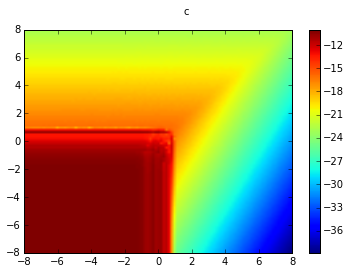

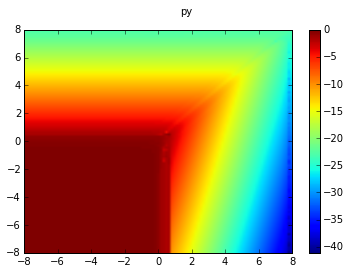

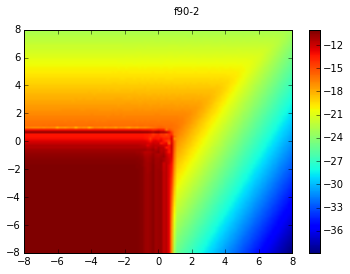

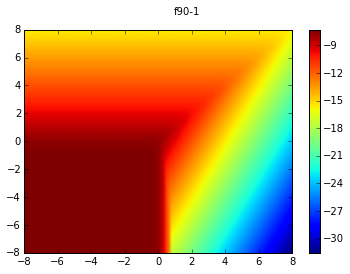

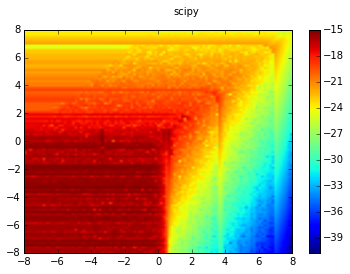

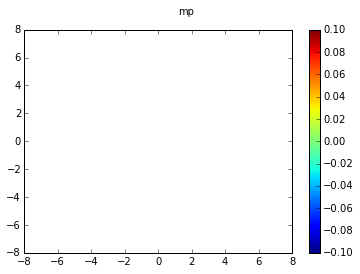

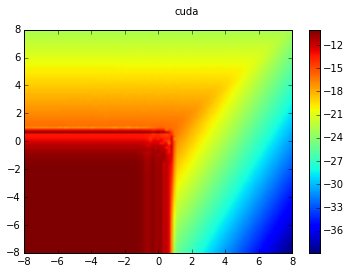

In [30]:
for implementation, function in wofz_impl.iteritems():
    wr, wi = function(x, y)
    plt.figure()
    plt.imshow(np.vectorize(mpmath.log10)(abs(wr - wr_ref)).astype(np.float64),
               origin="bottom",extent=[exp_min,exp_max,exp_min,exp_max],aspect='auto')
    plt.colorbar()
    plt.suptitle(implementation)

## III. Timing Benchmark

to be provided